In [1]:
import subprocess
import shlex

import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import binom
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, Markdown

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
lookuptable = np.array([bin(i).count('1') for i in range(256)]).astype(np.int32)

def countbits(v):
    assert v.dtype in (np.uint8, np.uint16, np.uint32, np.uint64), 'must be an unsigned int dtype'
    
    return lookuptable[np.reshape(v.view(np.uint8), v.shape + (-1, ))].sum(axis=-1)

# Avalanche Criterion for RNG state update

In [4]:
def test_rng_update_avalanche(seed=42, limit=1000, flags=[], title="Input-Hash bit dependence"):
    display(Markdown(f"## Diffusion: {', '.join(flags) or 'full'}"))
    
    flags = ' '.join(f'--{flag}' for flag in flags)
    
    hash_differences = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --seed {seed} --limit {limit} {flags} {'update'}"
    ), check=True, capture_output=True, text=True)
    
    differences = np.fromstring(hash_differences.stdout, dtype="uint64", sep='\n')
    
    display(Markdown("#### Single-bit-flip hash Hamming distance histogram:"))
    
    # Hamming distance histogram
    plt.title("Hamming distance after a single input bit flip")
    plt.xlabel("hamming distance")
    plt.ylabel("pmf")
    
    x = np.linspace(0, 64, 65)
    p = binom.pmf(x, 64, 0.5)
    plt.plot(x, p, color='red', linewidth=2, alpha=0.5, label="expected: mean=0.5")
    
    plt.hist(
        countbits(differences), bins=[x - 0.5 for x in range(0, 66)],
        density=True, label=f"observed: mean≈{round(np.mean(countbits(differences)) / 64, 3)}"
    )

    plt.legend()
    plt.show()
    
    # Calculate bit dependence matrix
    bit_dependence = np.zeros(shape=(64, 64), dtype="uint64")
    bit_normalisation = np.zeros(shape=(64), dtype="uint64")

    for bit, difference in enumerate(differences):
        bit_normalisation[bit % 64] += 1

        mask = np.uint64(0x1)

        for b in range(0, 64):
            if difference & mask:
                bit_dependence[bit % 64, b] += 1

            mask <<= np.uint64(1)
    
    avalanche_probability_vector = bit_dependence.sum(axis=0) / len(differences)
    
    display(Markdown("#### Avalanche statistics:"))
    
    # Avalanche dependence: Satisfied iff == 64
    avalanche_dependence = 64 - np.sum(avalanche_probability_vector == 0.0)
    display(Markdown(
        f"* avalanche dependence: {avalanche_dependence} " +
        "*(number of output bits that may flip for a single-bit " +
        "change at the input, should be = 64)*"
    ))
    
    # Avalanche weight: Satisfied iff ~~ 32
    avalanche_weight = np.sum(avalanche_probability_vector)
    display(Markdown(
        f"* avalanche weight: {avalanche_weight} " +
        "*(expected Hamming weight of the output difference, should be ≈ 32)*"
    ))
    
    # Avalanche entropy: Satisfied iff ~~ 64
    avalanche_entropy = np.sum(
        -avalanche_probability_vector * np.log2(avalanche_probability_vector)
        -(1.0 - avalanche_probability_vector) * np.log2(1.0 - avalanche_probability_vector)
    )
    display(Markdown(
        f"* avalanche entropy: {avalanche_entropy} " +
        "*(number of bits required to represent the uncertainty about " +
        "whether output bits flip or not, should be ≈ 64)*"
    ))
    
    display(Markdown("#### Avalanche diagram:"))
    
    # Avalanche diagram
    plt.figure(figsize=(8, 8))
    mat = plt.matshow((bit_dependence / bit_normalisation.reshape((64, 1))).T, vmin=0.0, vmax=1.0, fignum=1)
    mat.axes.set_title(title)
    mat.axes.set_xlabel("flip of input bit")
    mat.axes.set_ylabel("flip of output hash bit")
    plt.colorbar()
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seed: {seed}\n* limit: {limit}"))

## Diffusion: raw-output

#### Single-bit-flip hash Hamming distance histogram:

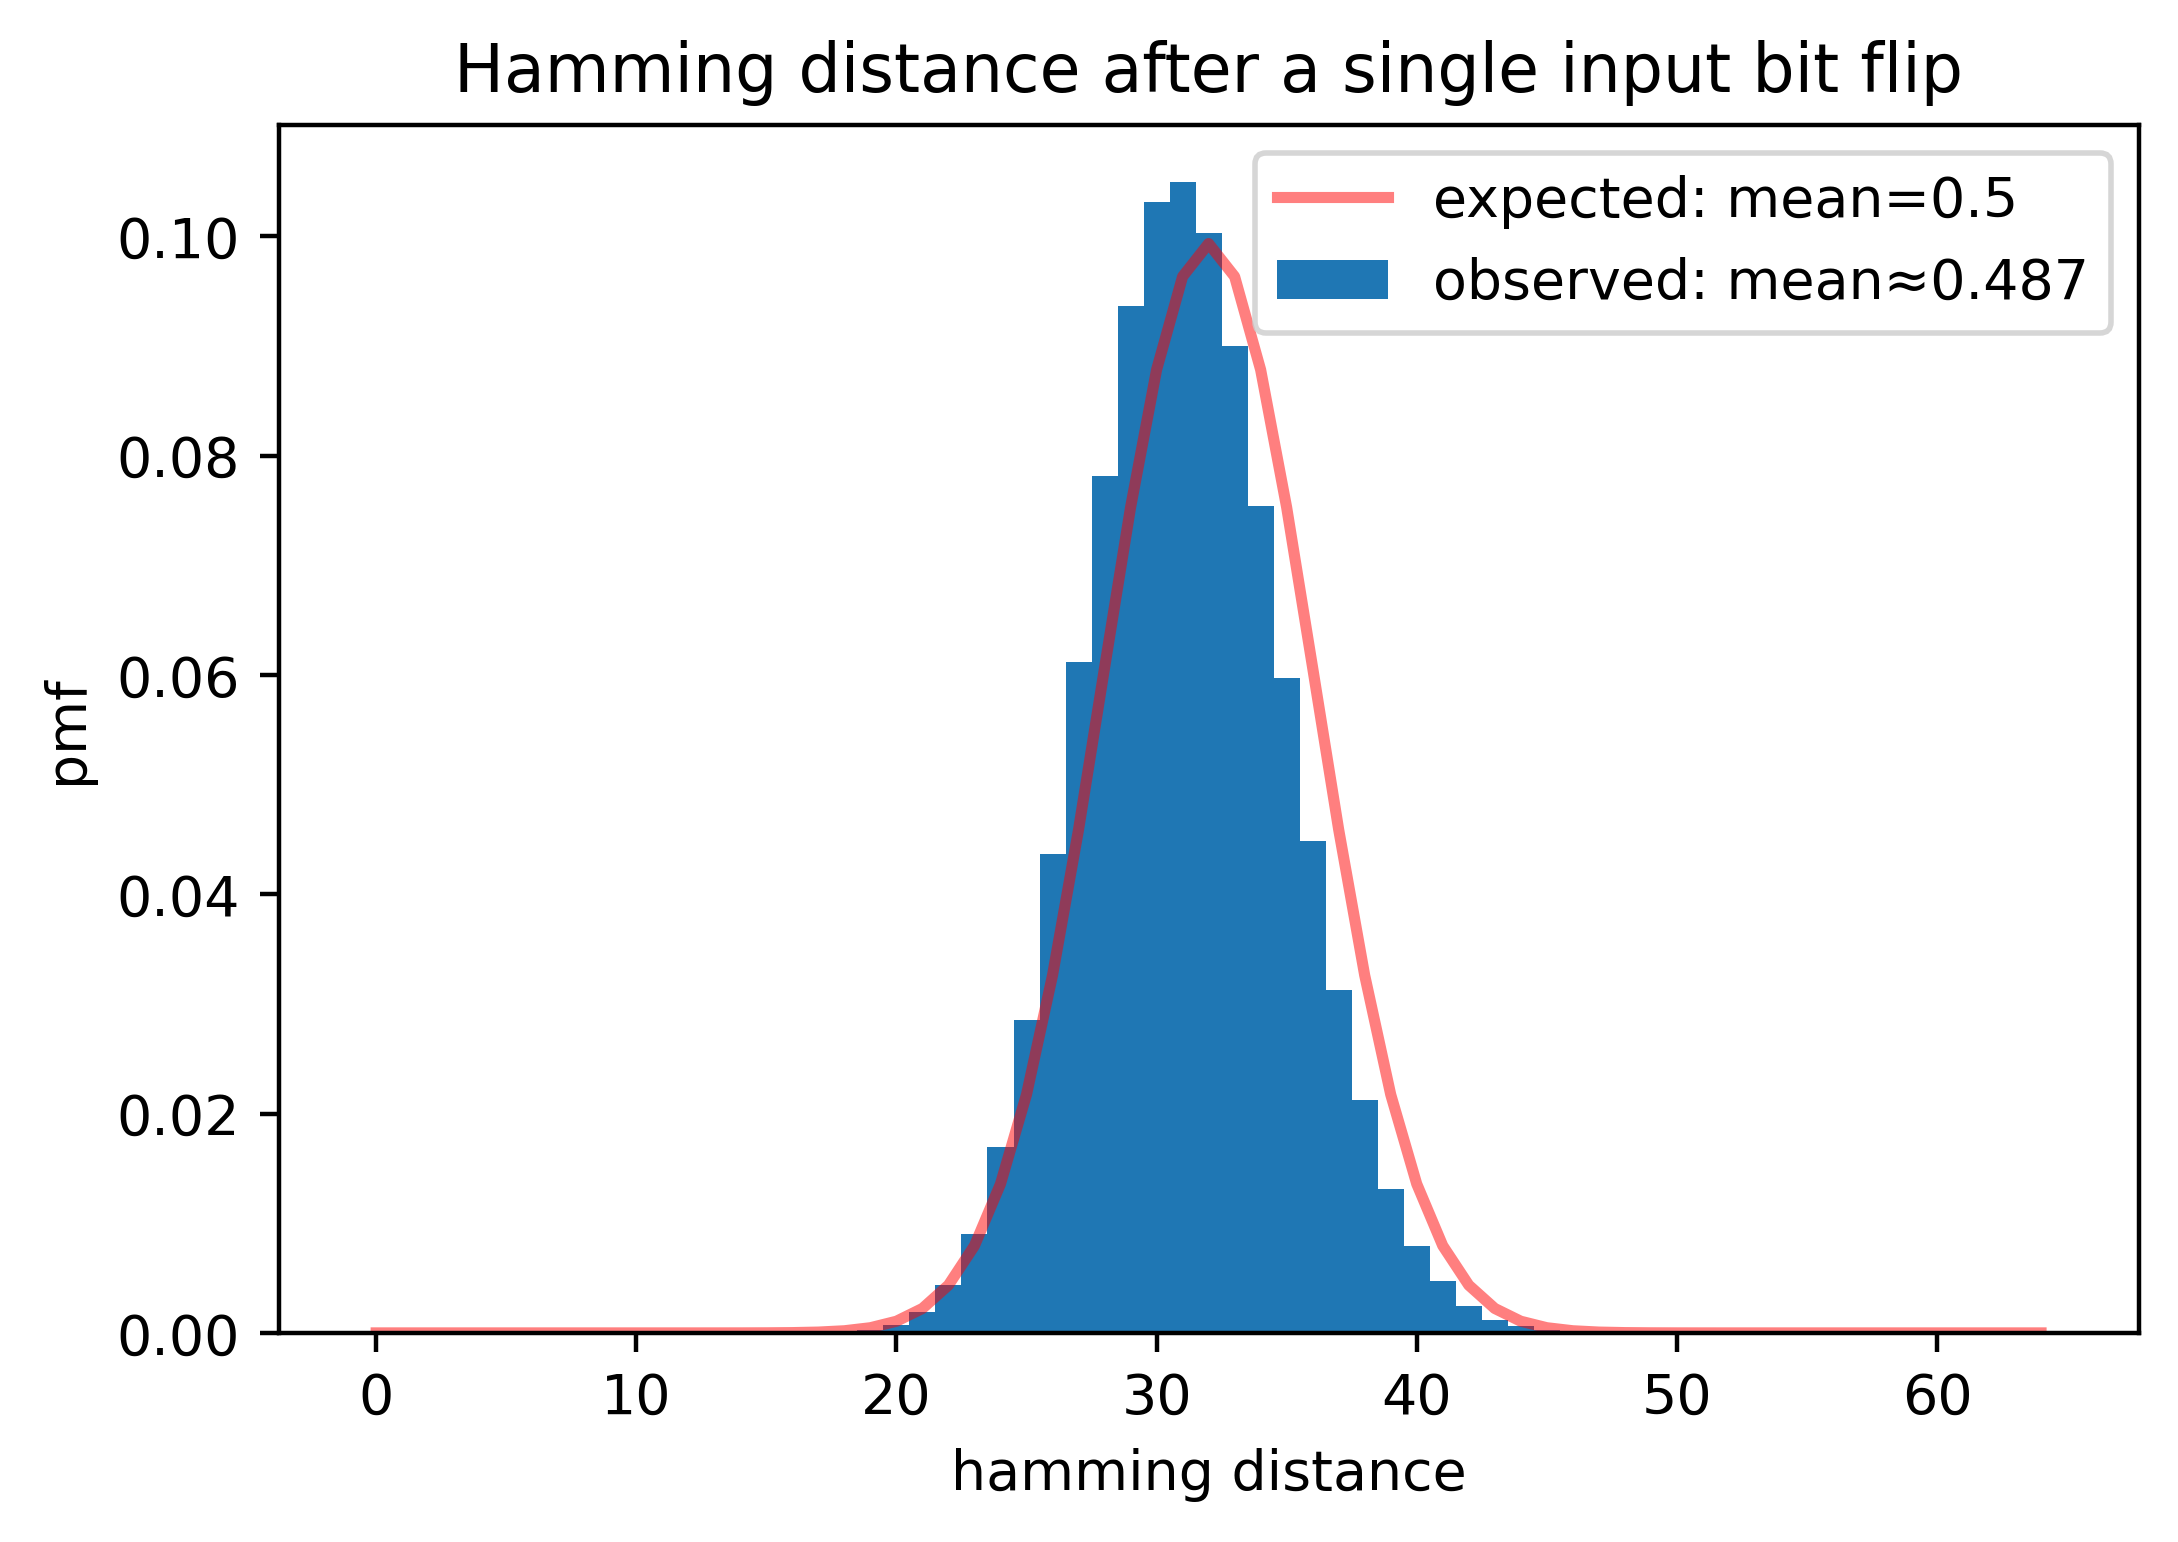

#### Avalanche statistics:

* avalanche dependence: 64 *(number of output bits that may flip for a single-bit change at the input, should be = 64)*

* avalanche weight: 31.162834620575882 *(expected Hamming weight of the output difference, should be ≈ 32)*

* avalanche entropy: 63.86526019437905 *(number of bits required to represent the uncertainty about whether output bits flip or not, should be ≈ 64)*

#### Avalanche diagram:

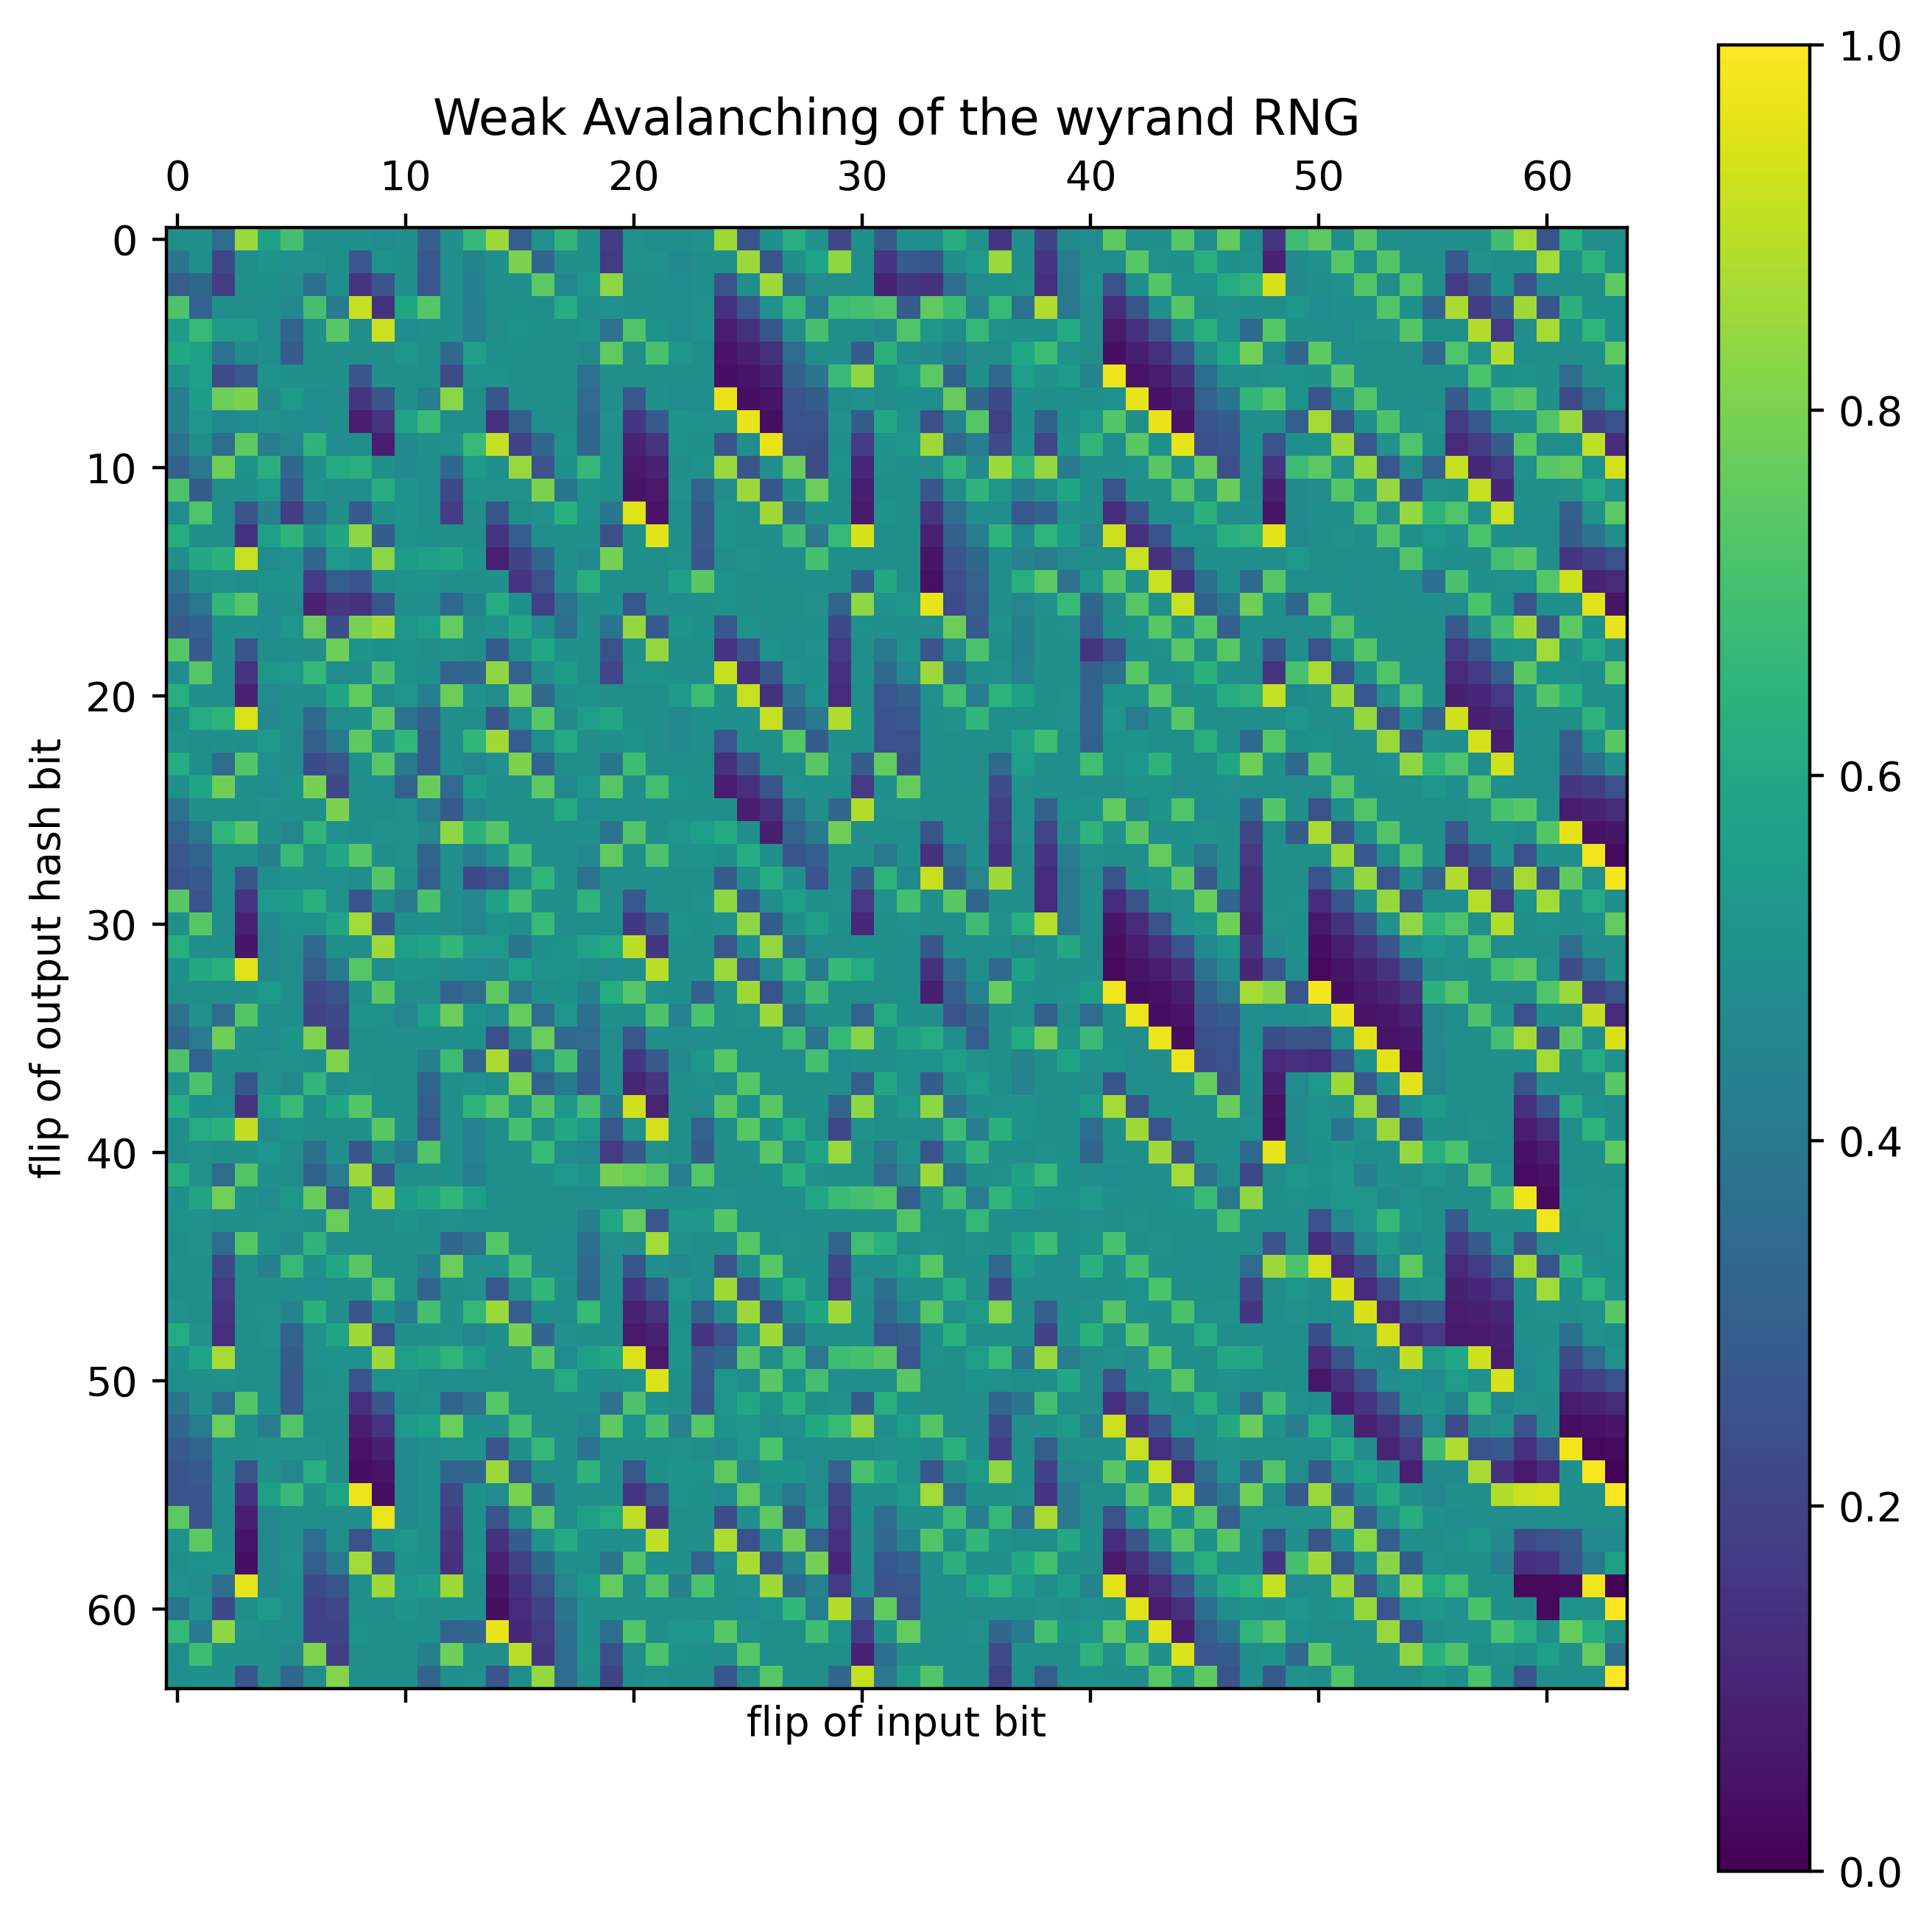

#### Parameters:
* seed: 17410920024718266035
* limit: 10000

## Diffusion: full

#### Single-bit-flip hash Hamming distance histogram:

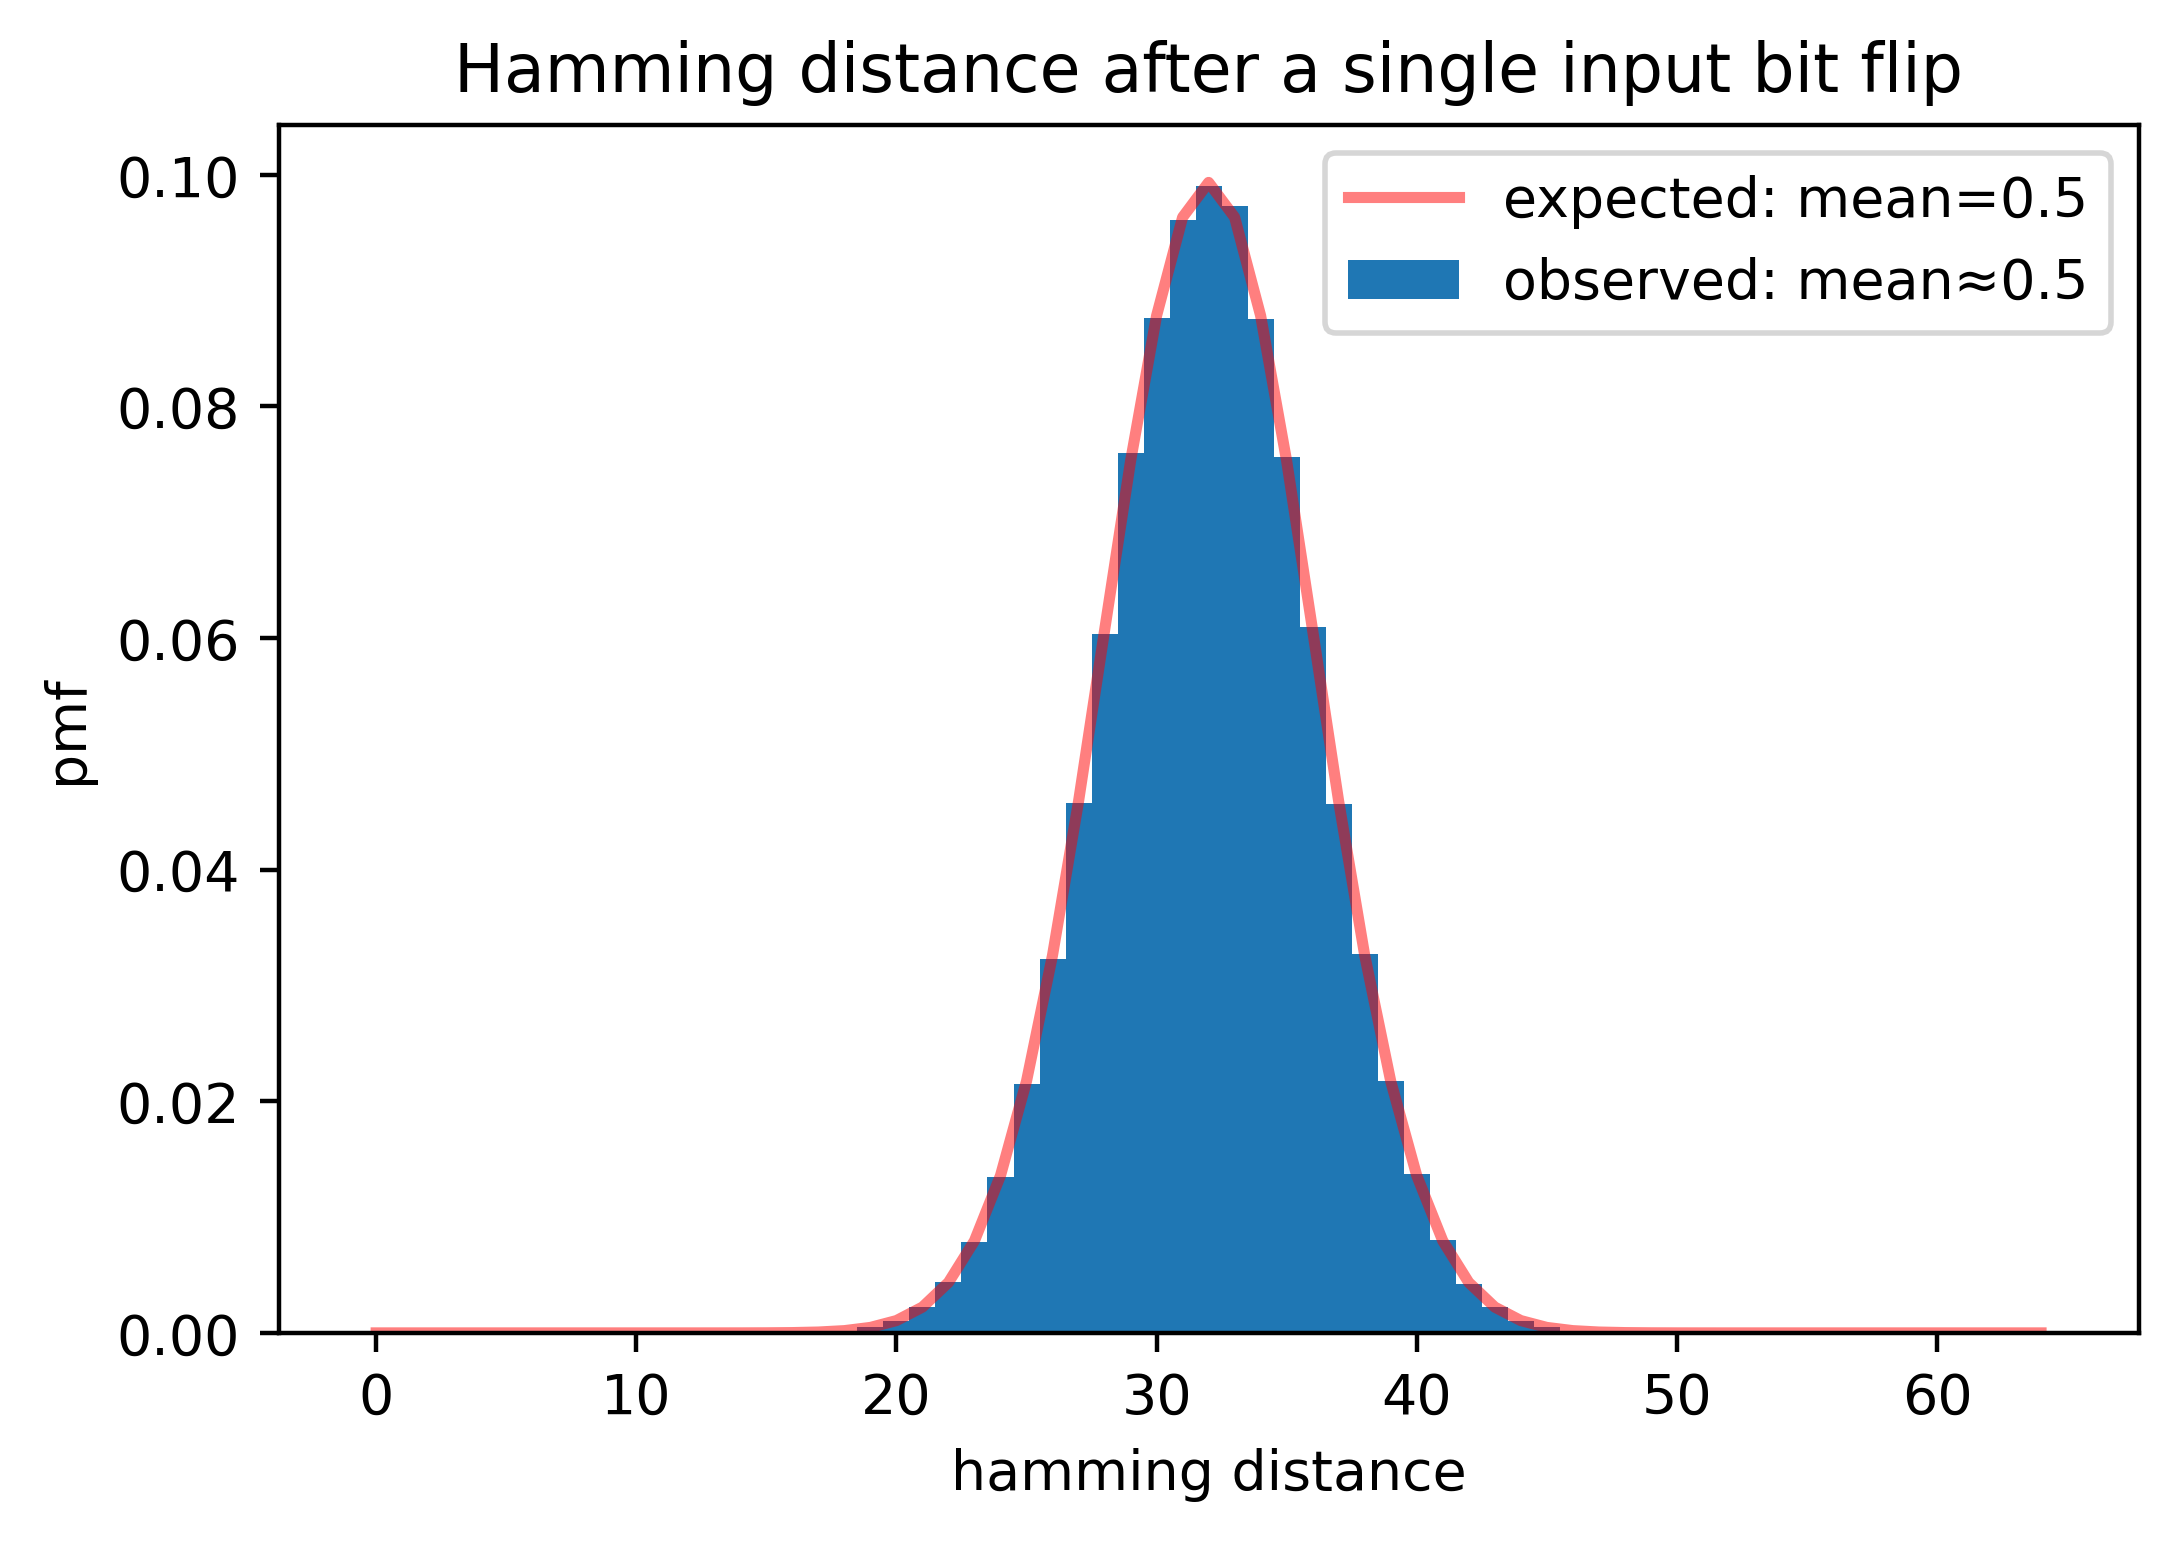

#### Avalanche statistics:

* avalanche dependence: 64 *(number of output bits that may flip for a single-bit change at the input, should be = 64)*

* avalanche weight: 32.008406131273745 *(expected Hamming weight of the output difference, should be ≈ 32)*

* avalanche entropy: 63.99992263159399 *(number of bits required to represent the uncertainty about whether output bits flip or not, should be ≈ 64)*

#### Avalanche diagram:

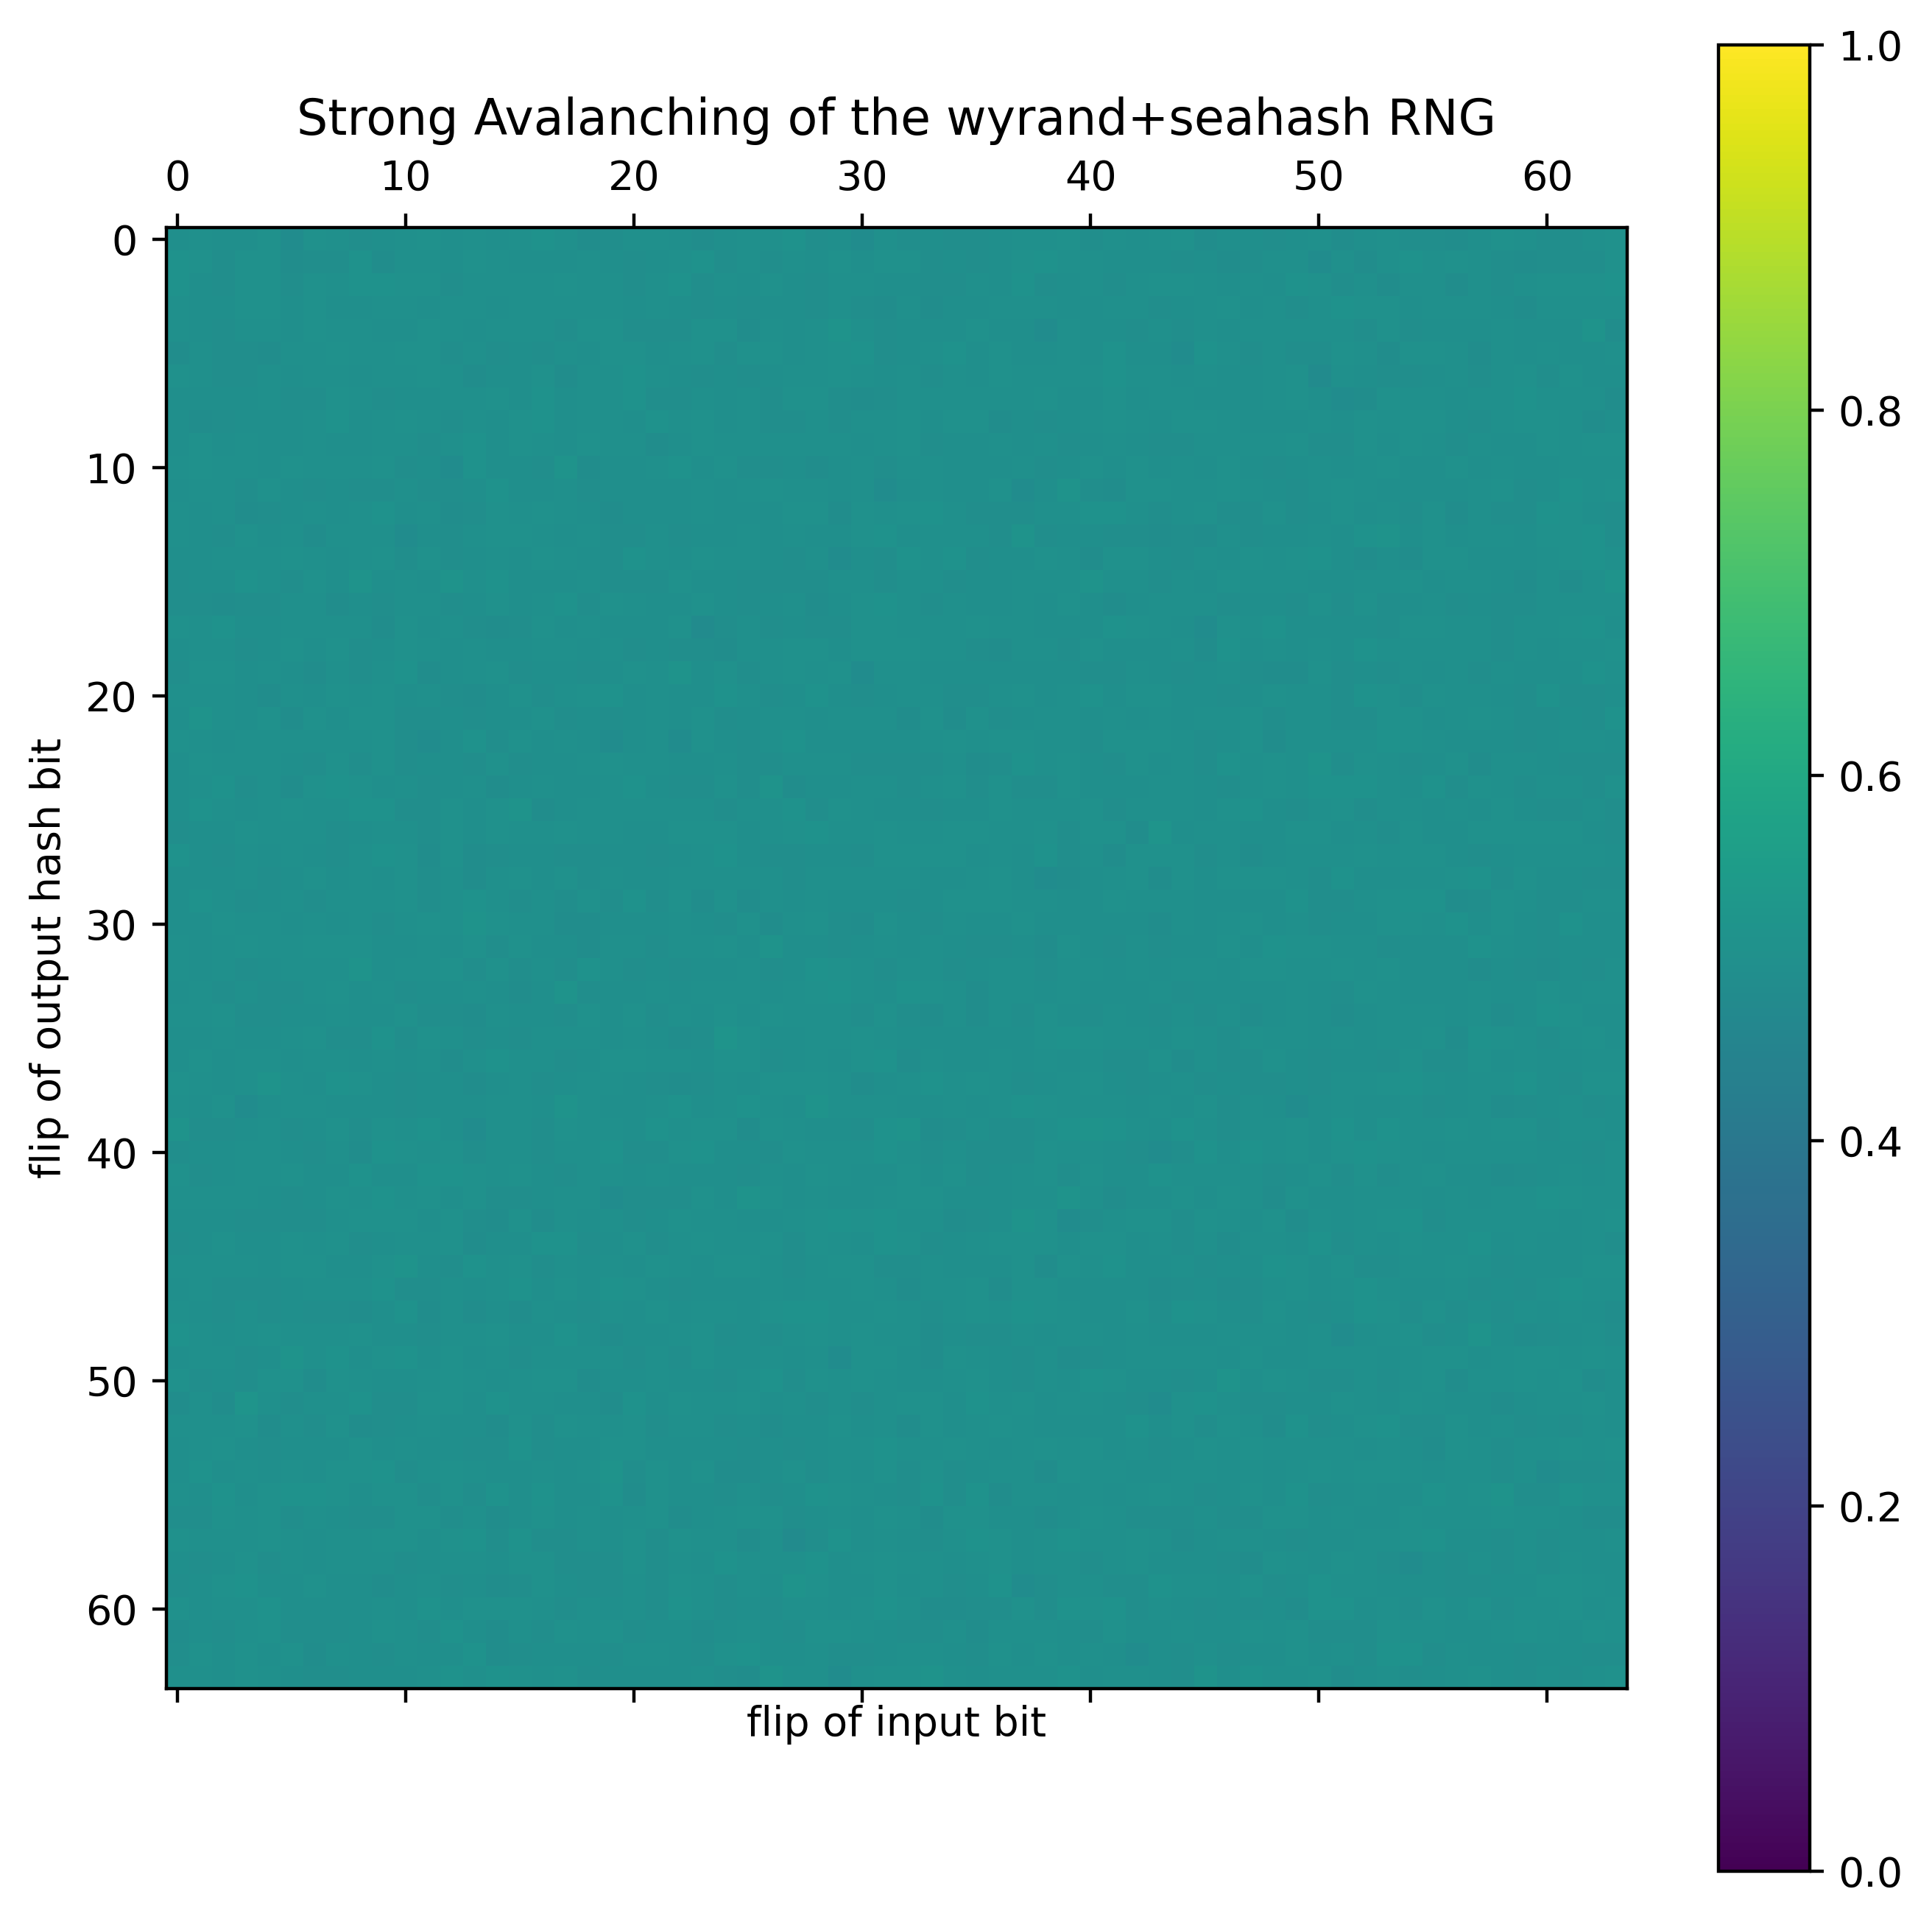

#### Parameters:
* seed: 17410920024718266035
* limit: 10000

In [5]:
seed = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64")

test_rng_update_avalanche(seed=seed, limit=10000, flags=["raw-output"], title="Weak Avalanching of the wyrand RNG")
test_rng_update_avalanche(seed=seed, limit=10000, flags=[], title="Strong Avalanching of the wyrand+seahash RNG")

# Avalanche Criterion for RNG priming

In [6]:
def test_rng_prime_avalanche(seed=42, limit=1000, flags=[]):
    display(Markdown(f"## Diffusion: {', '.join(flags) or 'full'}"))
    
    flags = ' '.join(f'--{flag}' for flag in flags)
    
    hash_differences = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --seed {seed} --limit {limit} {flags} {'prime'}"
    ), check=True, capture_output=True, text=True)
    
    differences = np.fromstring(hash_differences.stdout, dtype="uint64", sep='\n')
    
    display(Markdown("#### Single-bit-flip hash Hamming distance histogram:"))
    
    # Hamming distance histogram
    plt.title("Hamming distance after a single input bit flip")
    plt.xlabel("hamming distance")
    plt.ylabel("pmf")
    
    x = np.linspace(0, 64, 65)
    p = binom.pmf(x, 64, 0.5)
    plt.plot(x, p, color='red', linewidth=2, alpha=0.5, label="expected: mean=0.5")
    
    plt.hist(
        countbits(differences), bins=[x - 0.5 for x in range(0, 66)],
        density=True, label=f"observed: mean={round(np.mean(countbits(differences)) / 64, 3)}"
    )

    plt.legend()
    plt.show()
    
    # Calculate bit dependence matrix
    bit_dependence = np.zeros(shape=(64*3, 64), dtype="uint64")
    bit_normalisation = np.zeros(shape=(64*3), dtype="uint64")

    for bit, difference in enumerate(differences):
        bit_normalisation[bit % (64*3)] += 1

        mask = np.uint64(0x1)

        for b in range(0, 64):
            if difference & mask:
                bit_dependence[bit % (64*3), b] += 1

            mask <<= np.uint64(1)
    
    avalanche_probability_vector = bit_dependence.sum(axis=0) / len(differences)
    
    display(Markdown("#### Avalanche statistics:"))
    
    # Avalanche dependence: Satisfied iff == 64
    avalanche_dependence = 64 - np.sum(avalanche_probability_vector == 0.0)
    display(Markdown(
        f"* avalanche dependence: {avalanche_dependence} " +
        "*(number of output bits that may flip for a single-bit " +
        "change at the input, should be = 64)*"
    ))
    
    # Avalanche weight: Satisfied iff ~~ 32
    avalanche_weight = np.sum(avalanche_probability_vector)
    display(Markdown(
        f"* avalanche weight: {avalanche_weight} " +
        "*(expected Hamming weight of the output difference, should be ≈ 32)*"
    ))
    
    # Avalanche entropy: Satisfied iff ~~ 64
    avalanche_entropy = np.sum(
        -avalanche_probability_vector * np.log2(avalanche_probability_vector)
        -(1.0 - avalanche_probability_vector) * np.log2(1.0 - avalanche_probability_vector)
    )
    display(Markdown(
        f"* avalanche entropy: {avalanche_entropy} " +
        "*(number of bits required to represent the uncertainty about " +
        "whether output bits flip or not, should be ≈ 64)*"
    ))
    
    display(Markdown("#### Avalanche diagram:"))
    
    # Avalanche diagram
    plt.figure(figsize=(24, 8))
    mat = plt.matshow((bit_dependence / bit_normalisation.reshape((64*3, 1))).T, vmin=0.0, vmax=1.0, fignum=1)
    mat.axes.set_title("Input-Hash bit dependence")
    mat.axes.set_xlabel("flip of input bit")
    mat.axes.set_ylabel("flip of output hash bit")
    plt.colorbar()
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seed: {seed}\n* limit: {limit}"))

## Diffusion: raw-prime, raw-output

#### Single-bit-flip hash Hamming distance histogram:

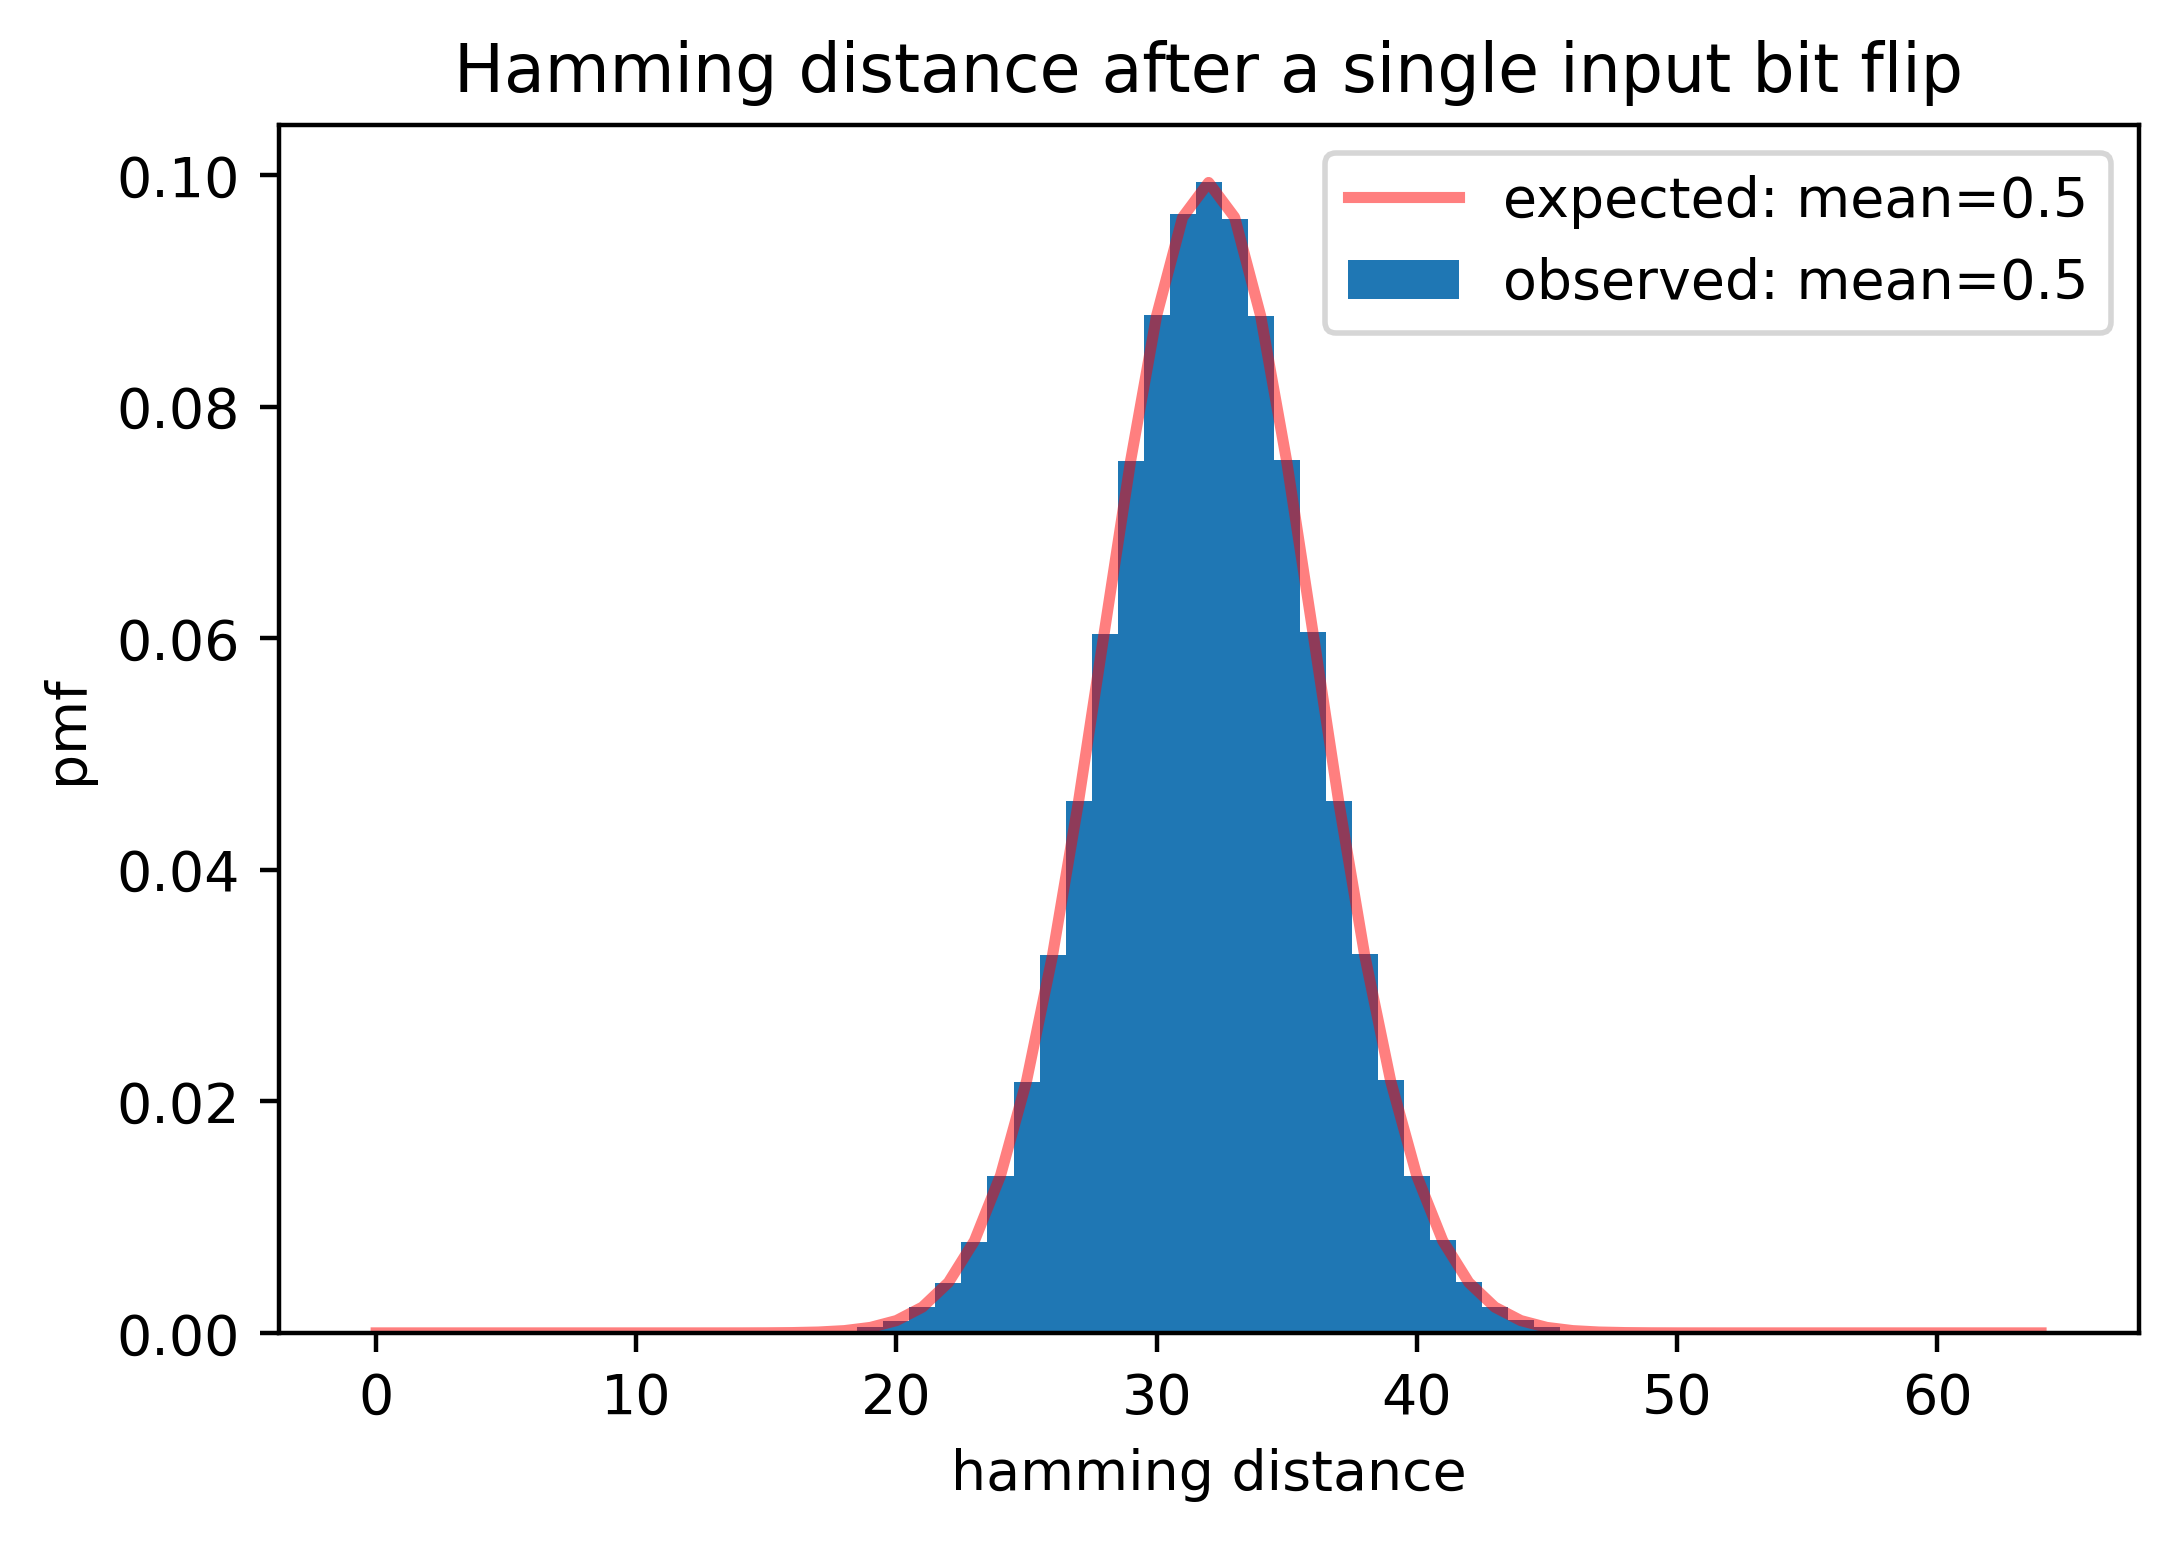

#### Avalanche statistics:

* avalanche dependence: 64 *(number of output bits that may flip for a single-bit change at the input, should be = 64)*

* avalanche weight: 32.00457304372459 *(expected Hamming weight of the output difference, should be ≈ 32)*

* avalanche entropy: 63.999976729449116 *(number of bits required to represent the uncertainty about whether output bits flip or not, should be ≈ 64)*

#### Avalanche diagram:

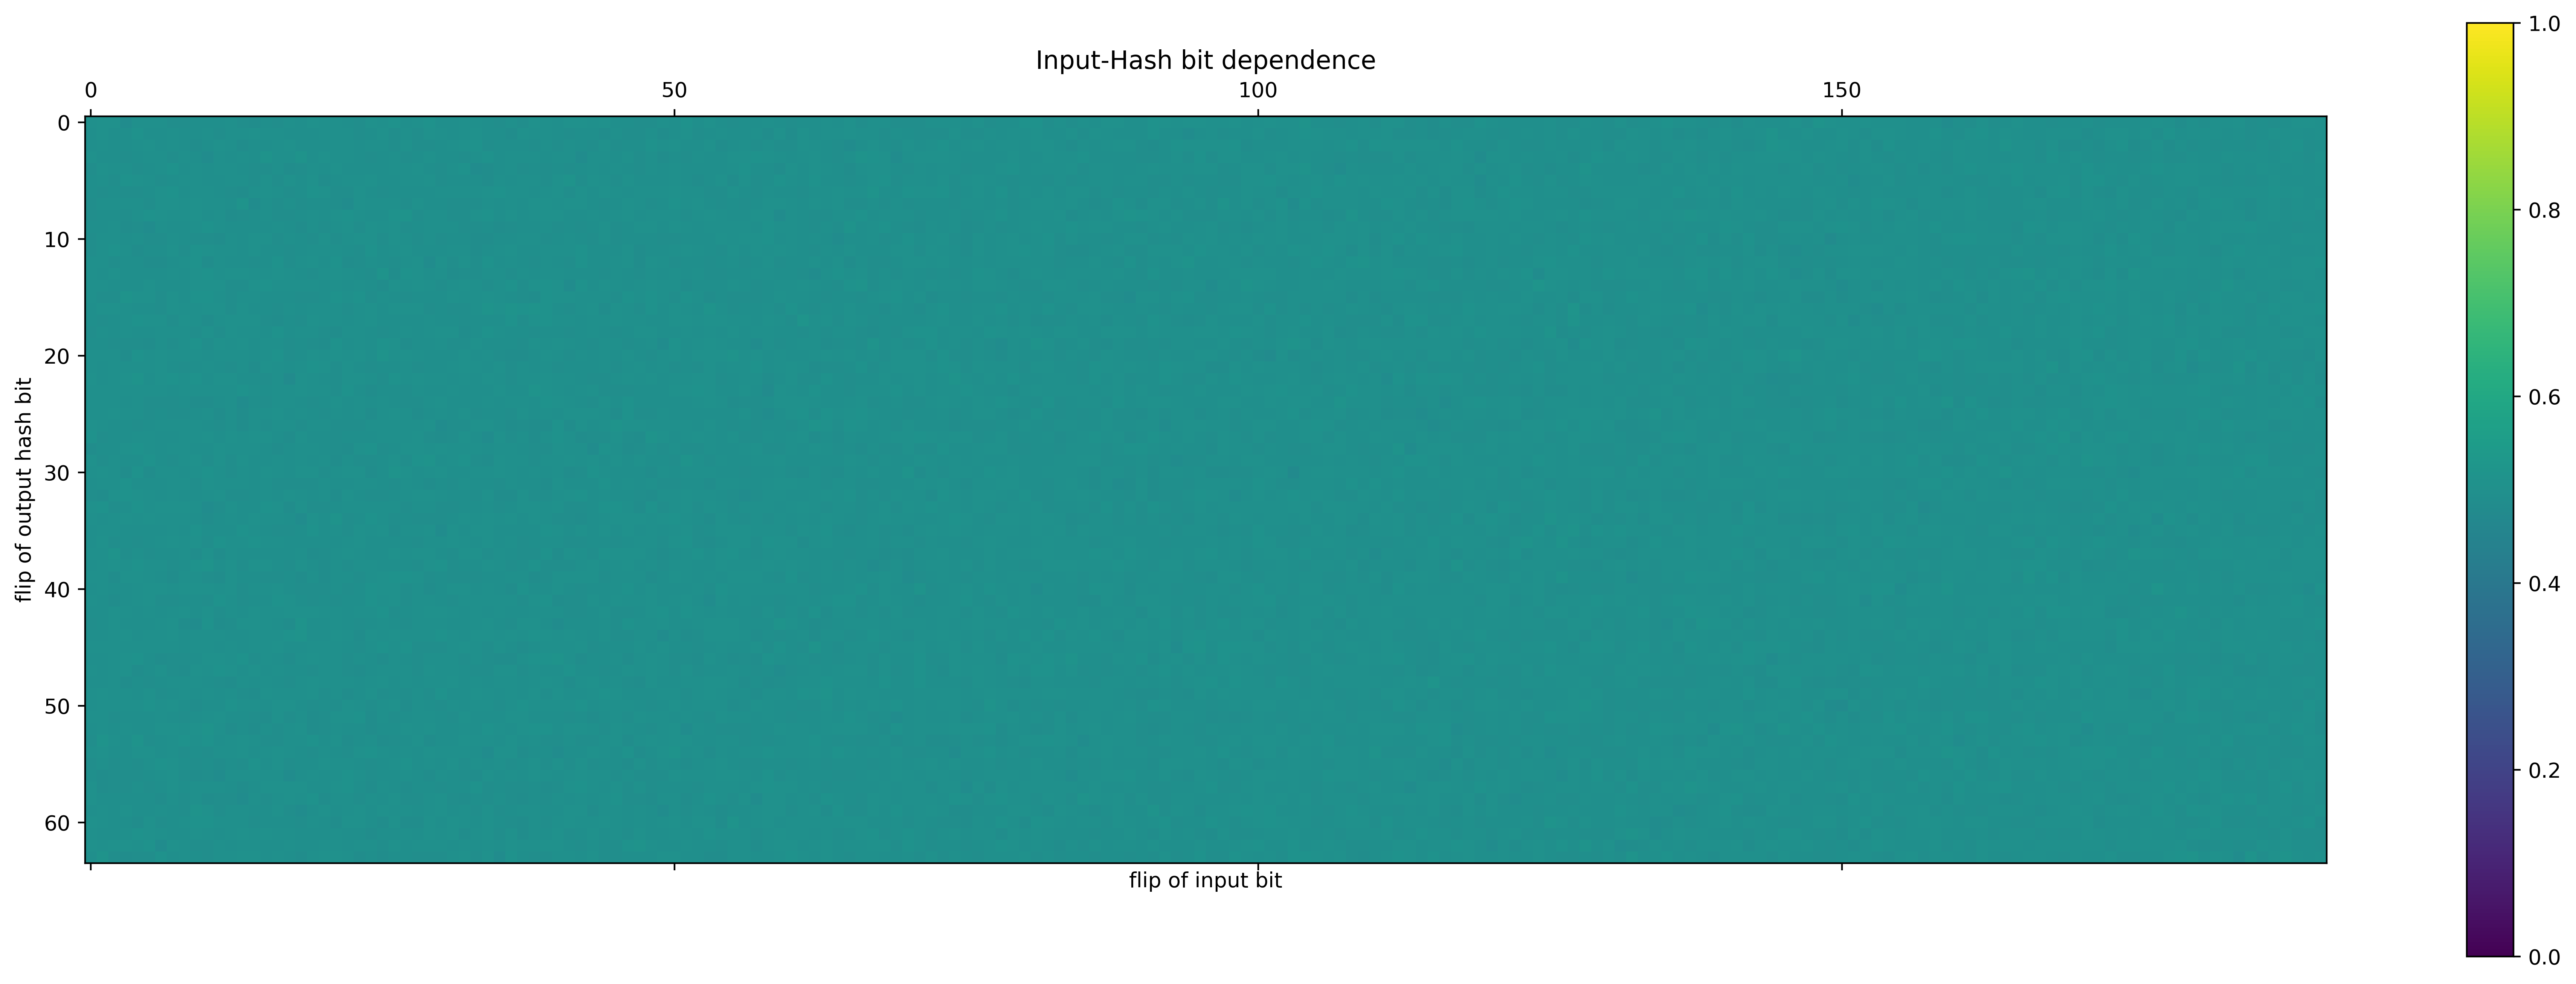

#### Parameters:
* seed: 5174992429362914038
* limit: 10000

## Diffusion: raw-output

#### Single-bit-flip hash Hamming distance histogram:

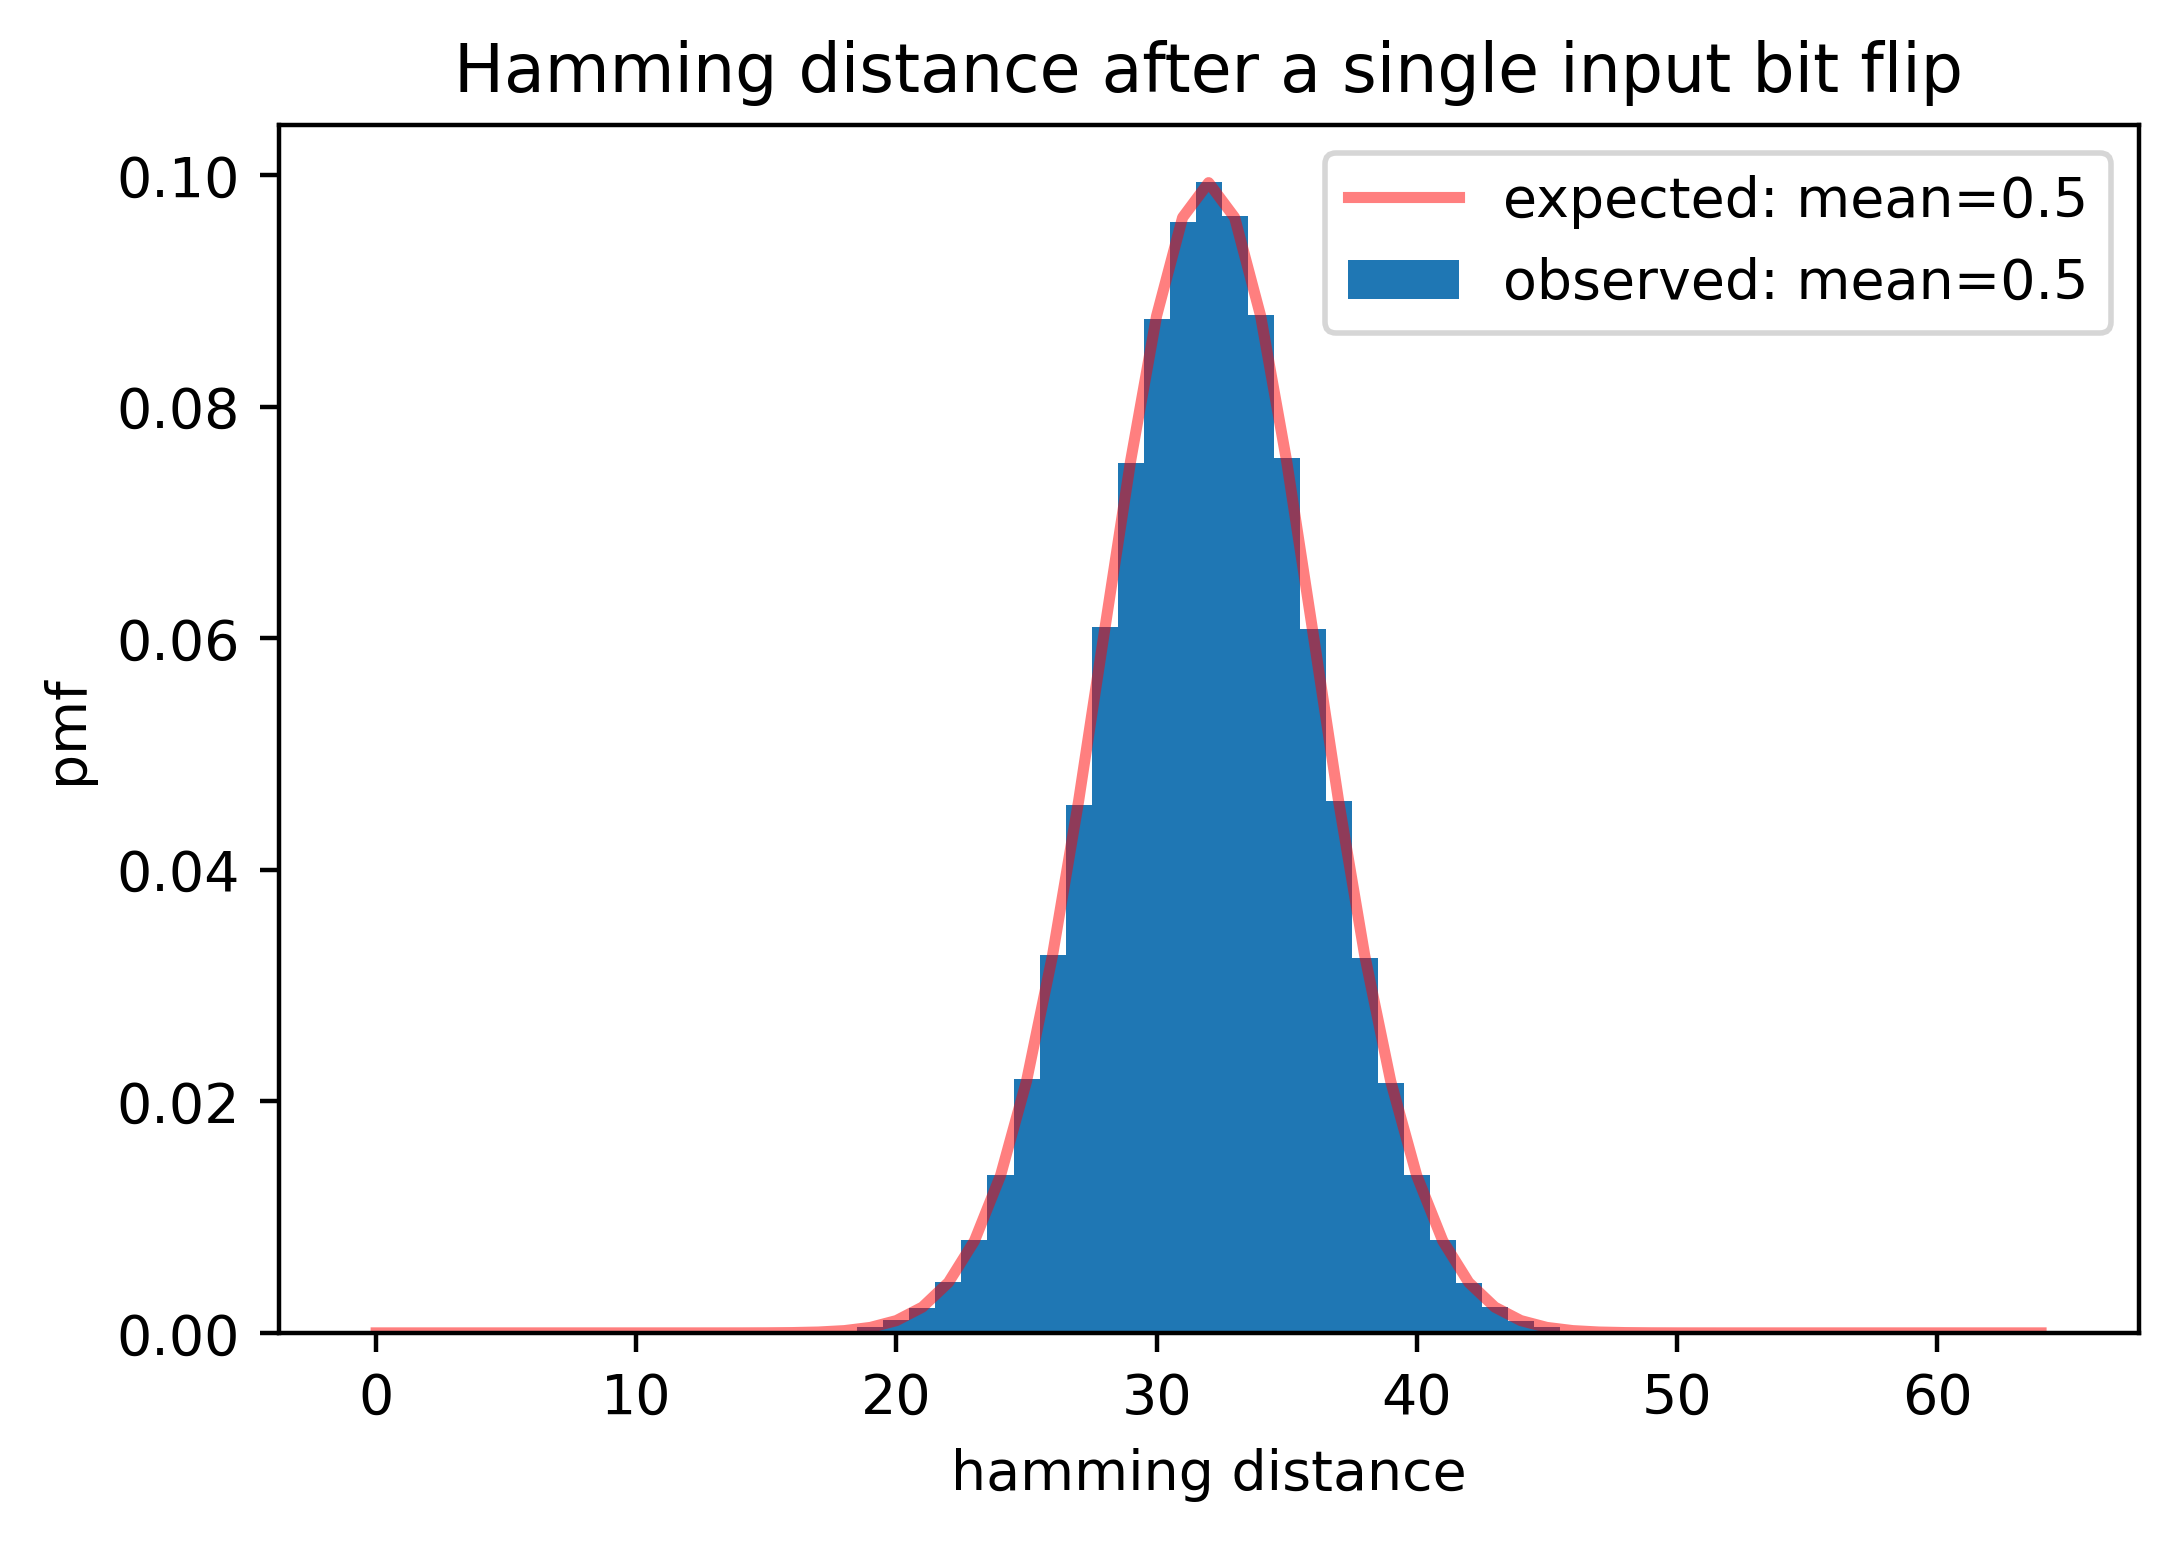

#### Avalanche statistics:

* avalanche dependence: 64 *(number of output bits that may flip for a single-bit change at the input, should be = 64)*

* avalanche weight: 31.999509473105377 *(expected Hamming weight of the output difference, should be ≈ 32)*

* avalanche entropy: 63.999979108121465 *(number of bits required to represent the uncertainty about whether output bits flip or not, should be ≈ 64)*

#### Avalanche diagram:

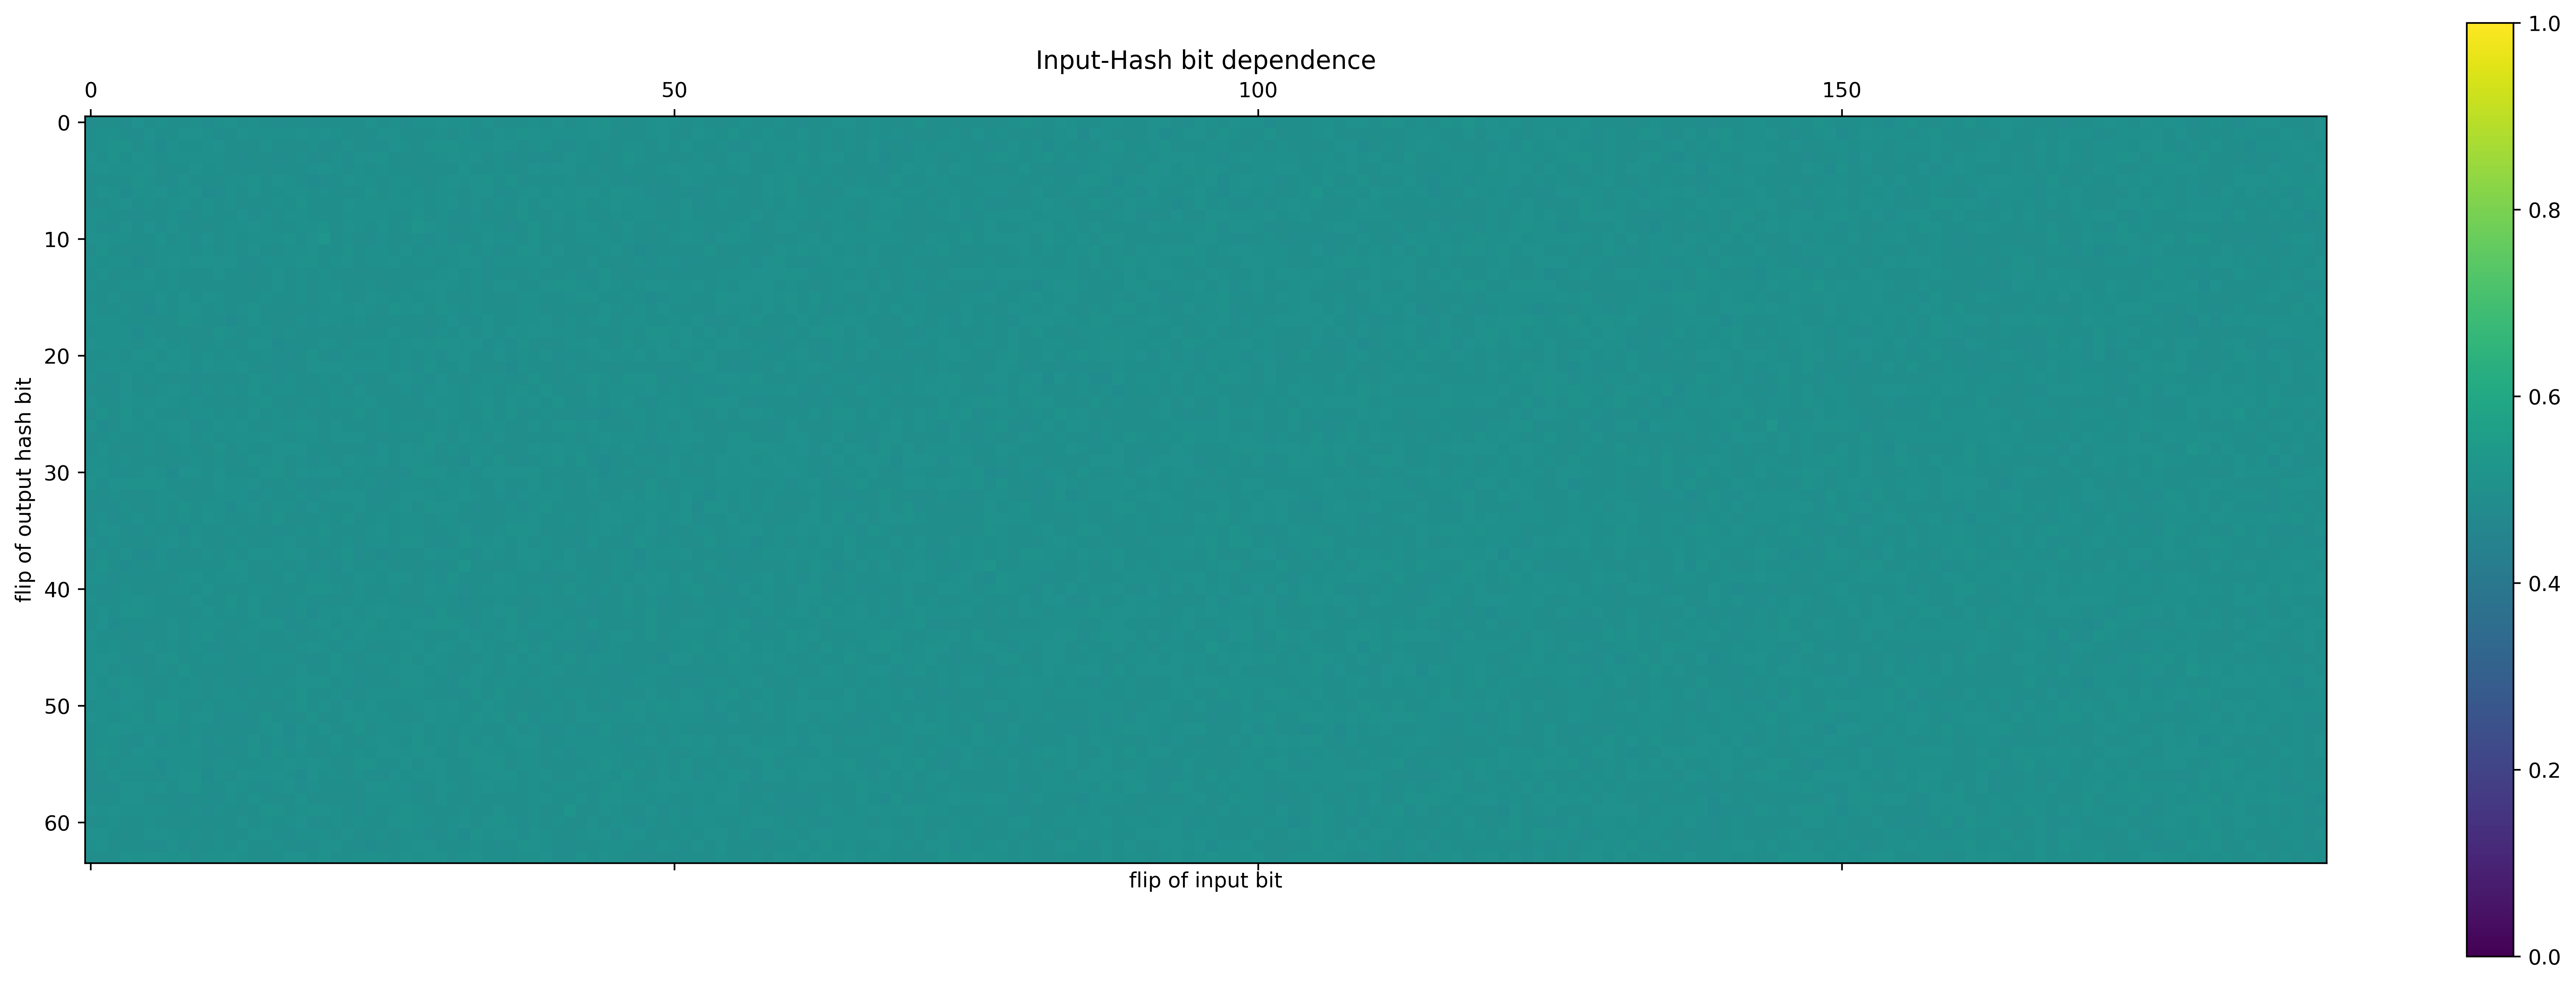

#### Parameters:
* seed: 5174992429362914038
* limit: 10000

## Diffusion: full

#### Single-bit-flip hash Hamming distance histogram:

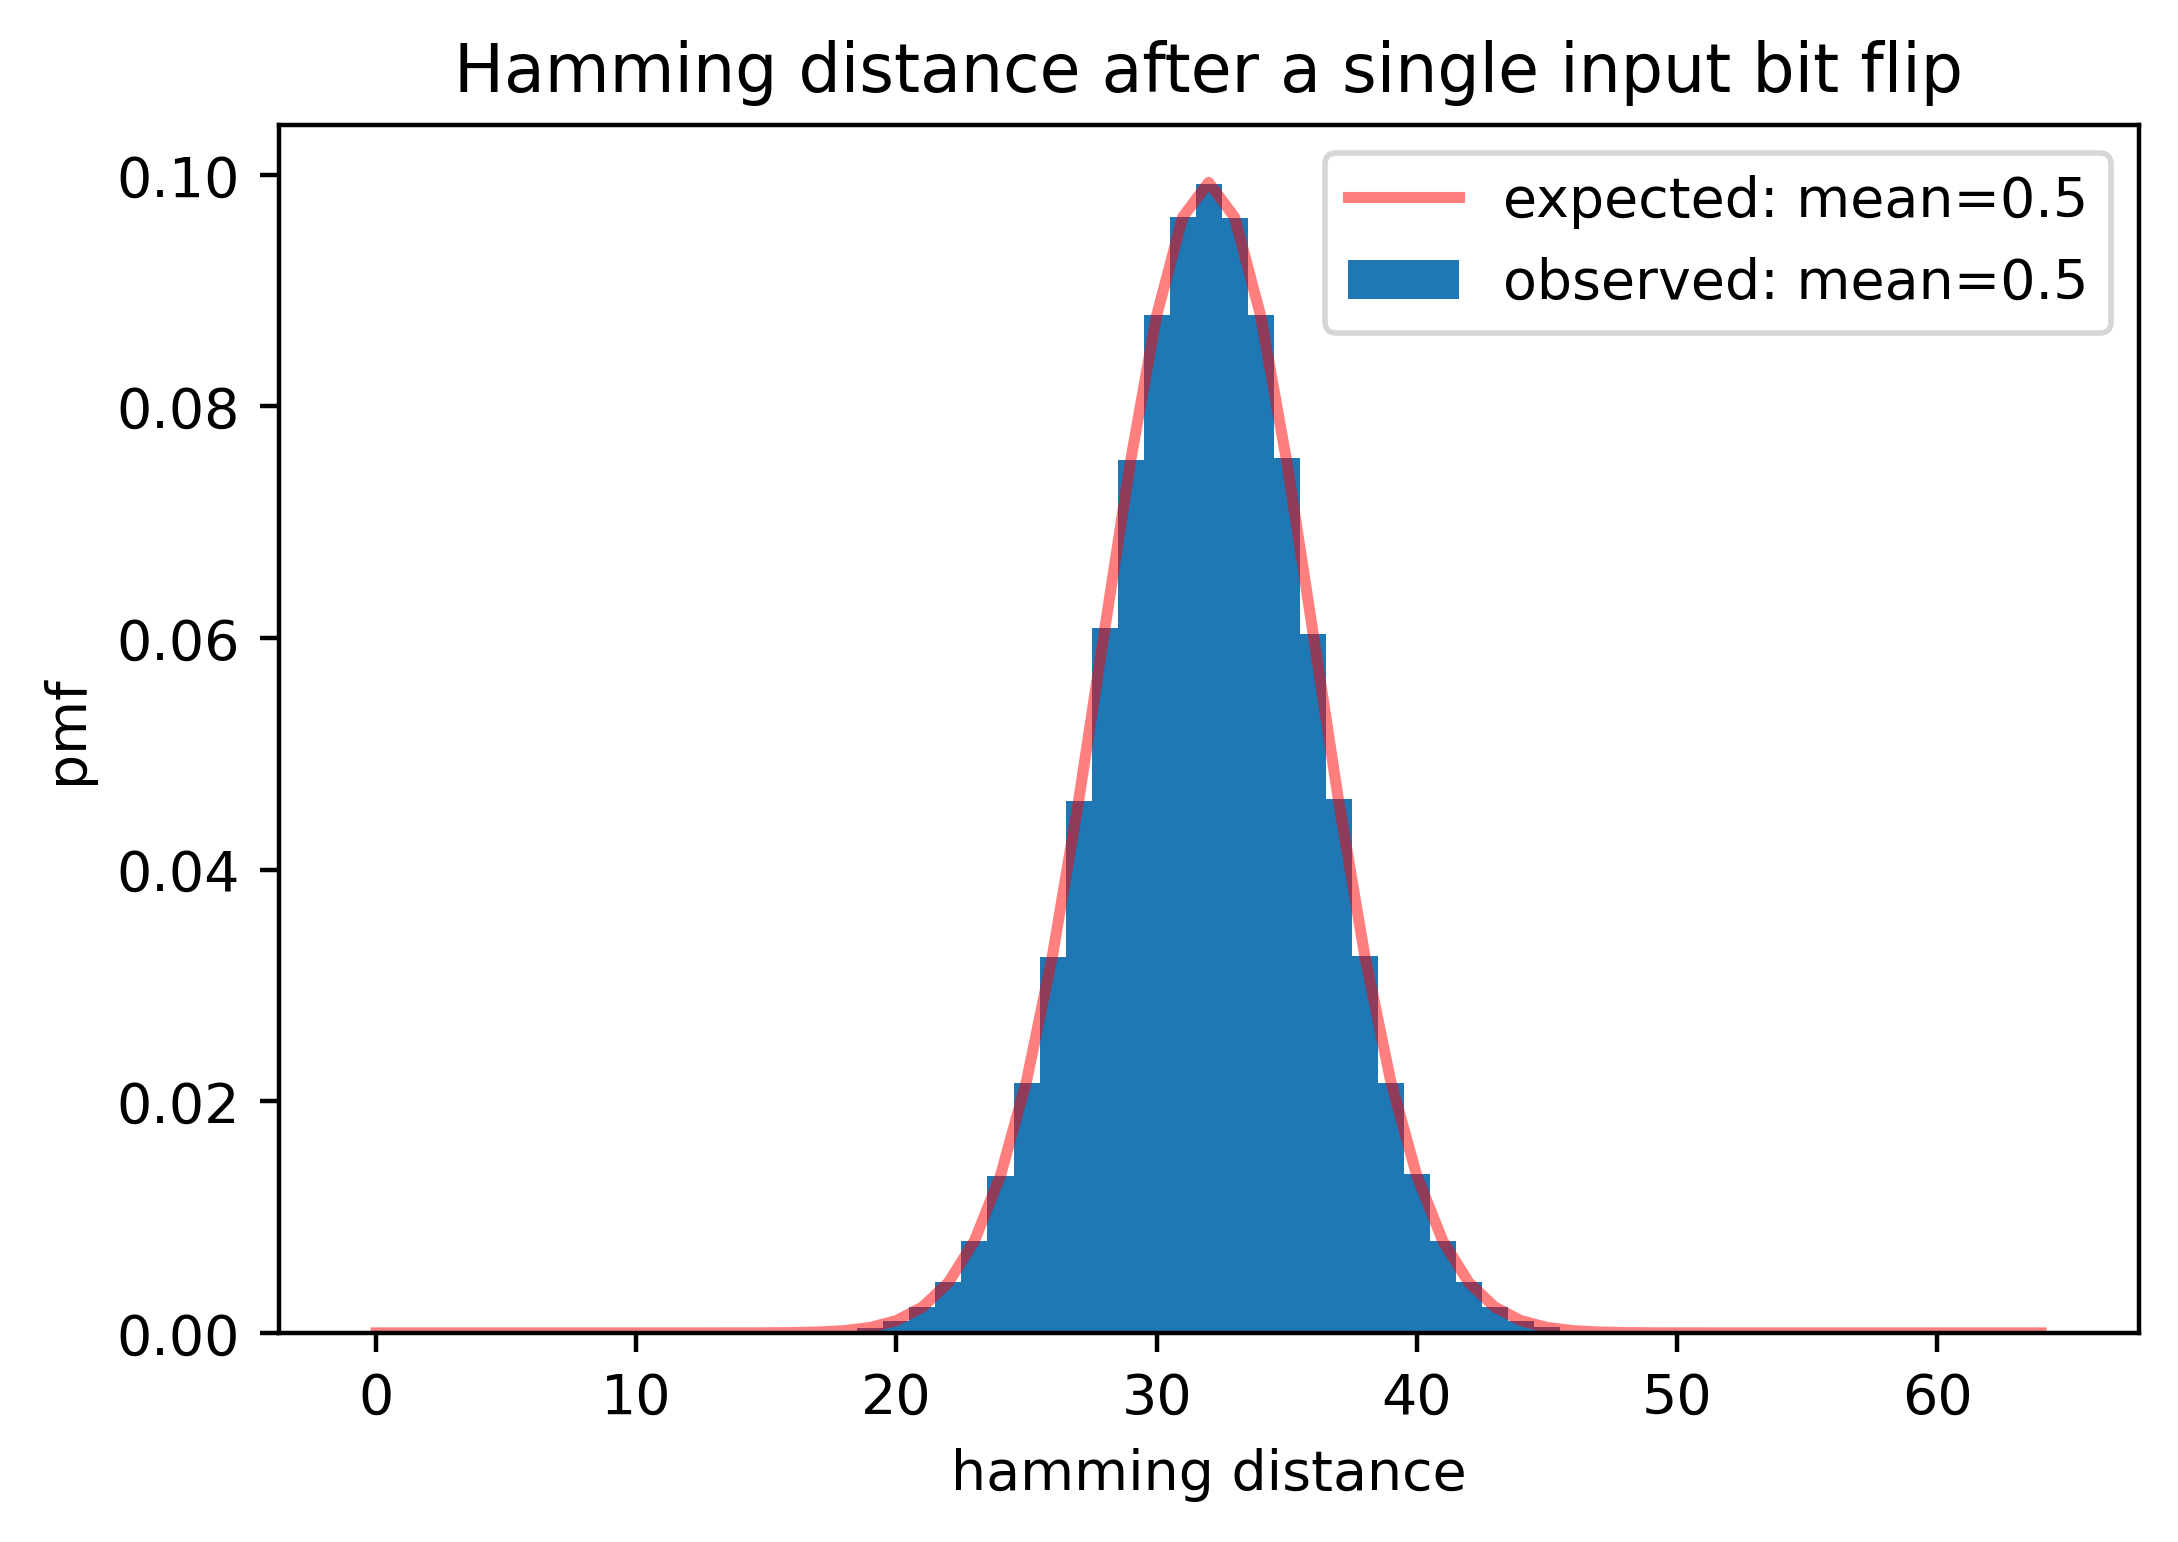

#### Avalanche statistics:

* avalanche dependence: 64 *(number of output bits that may flip for a single-bit change at the input, should be = 64)*

* avalanche weight: 32.000422311371054 *(expected Hamming weight of the output difference, should be ≈ 32)*

* avalanche entropy: 63.999977989867006 *(number of bits required to represent the uncertainty about whether output bits flip or not, should be ≈ 64)*

#### Avalanche diagram:

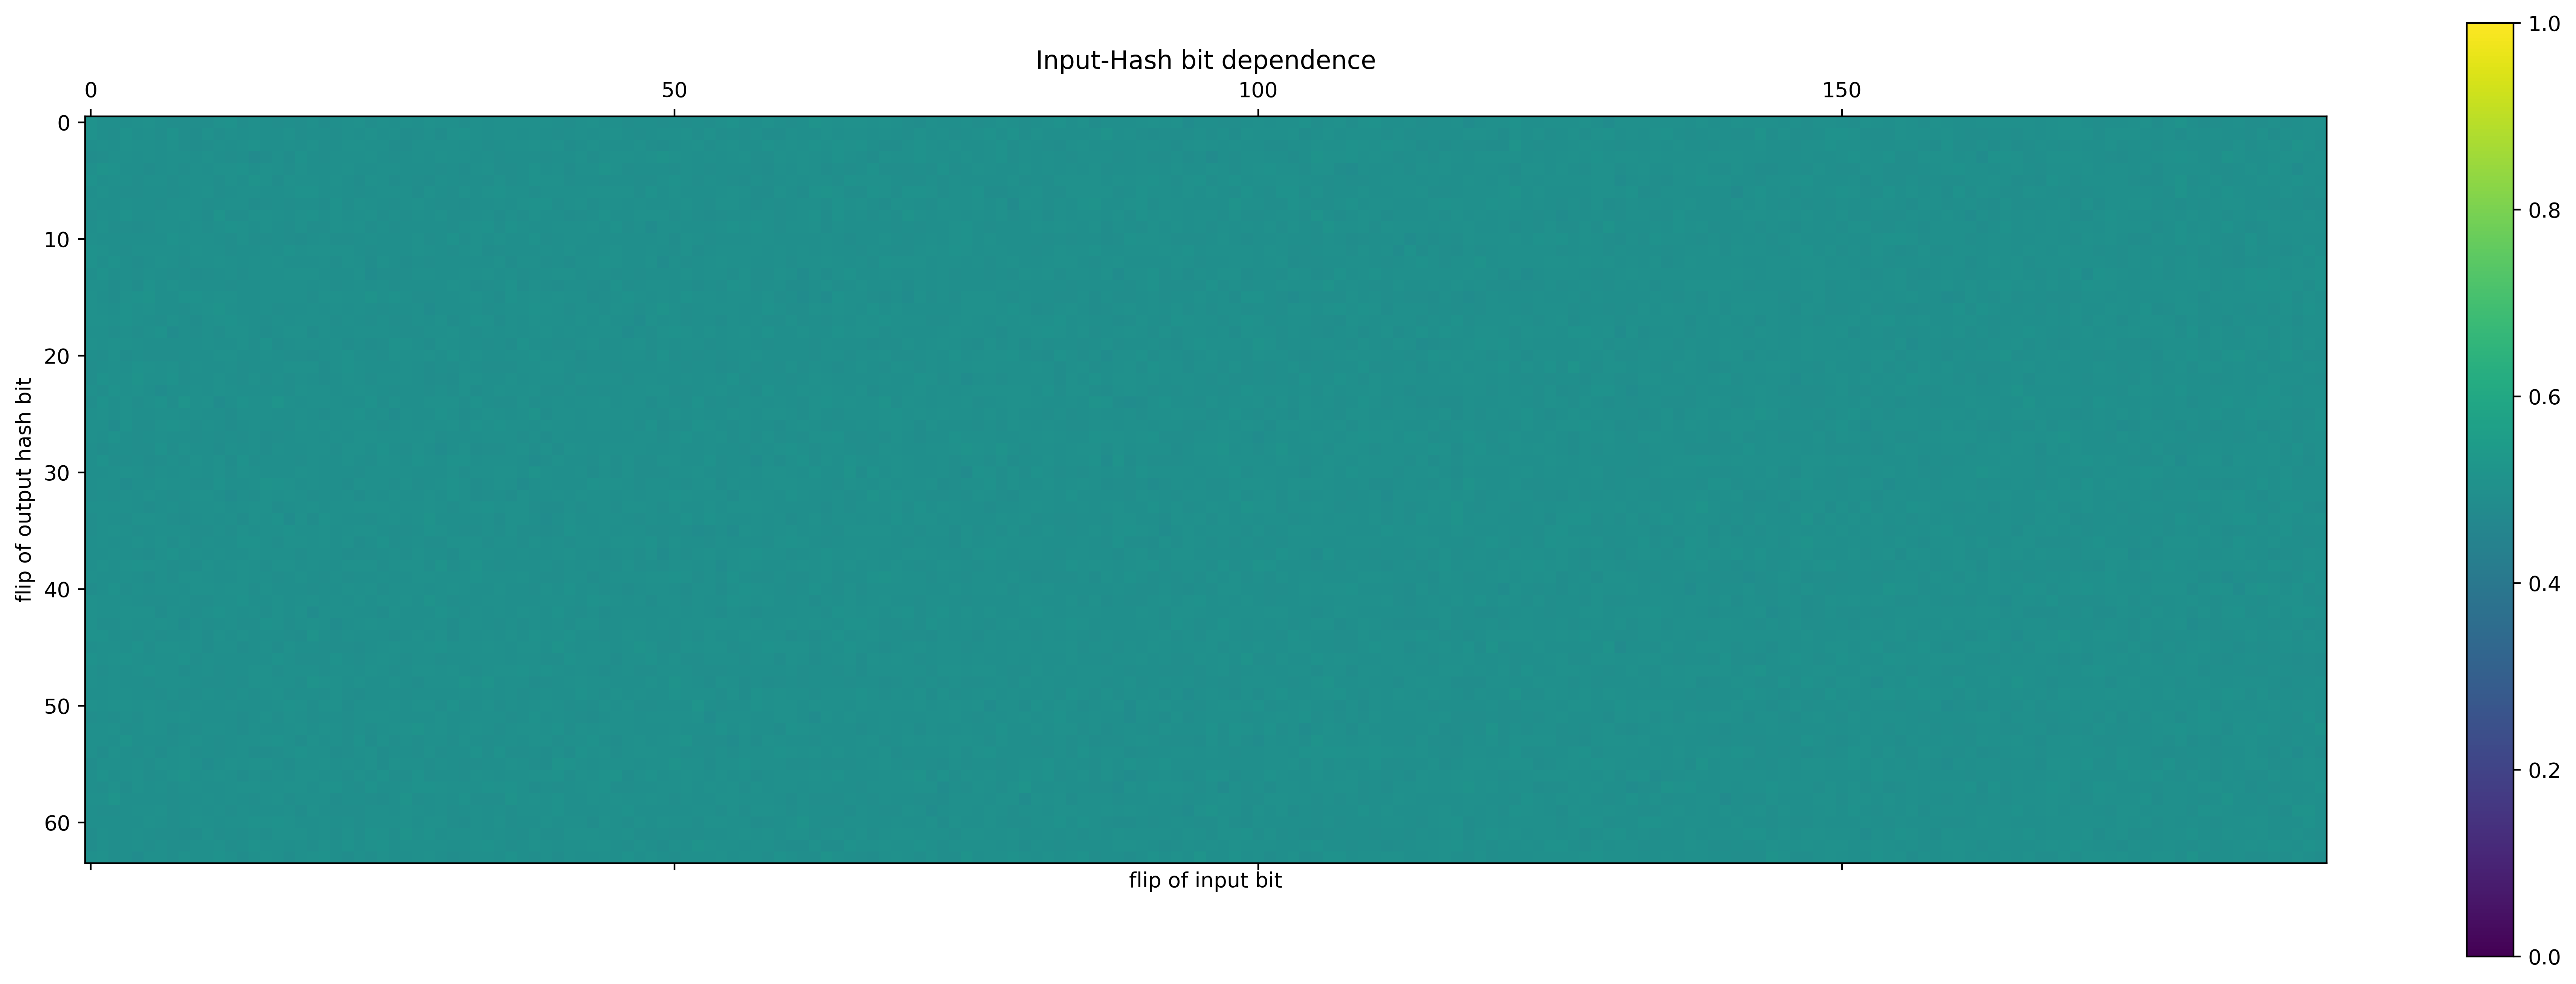

#### Parameters:
* seed: 5174992429362914038
* limit: 10000

In [7]:
seed = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64")

test_rng_prime_avalanche(seed=seed, limit=10000, flags=["raw-prime", "raw-output"])
test_rng_prime_avalanche(seed=seed, limit=10000, flags=["raw-output"])
test_rng_prime_avalanche(seed=seed, limit=10000, flags=[])